![Plain flap sketch](https://cdn.boldmethod.com/images/learn-to-fly/aircraft-systems/4-types-of-flaps/diagram-plain.jpg)

---

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import viiflow as vf
import viiflowtools.vf_plots as vfp
import viiflowtools.vf_tools as vft

from collections import defaultdict
from functools import partial

%matplotlib notebook
%config InlineBackend.figure_format = 'svg'
matplotlib.rcParams["figure.figsize"] = [10, 7]  # Make plots bigger than default

import logging

logging.getLogger().setLevel(logging.INFO)

In [2]:
savefig = partial(plt.savefig, dpi=300, transparent=True, bbox_inches="tight")

In [3]:
# Read and panel airfoil data
_main = vft.read_selig("NLR7301MainECARP.dat")

In [264]:
N_MAIN = 200
N_CHEBY = 100

In [265]:
MAIN = vft.repanel(_main, N_MAIN)[:, ::-1]

---

In [266]:
ROUND_DECIMALS = 8

main_df = pd.DataFrame(MAIN.T, columns = ["X", "Y"])
main_df = main_df.round(ROUND_DECIMALS)

# Split into upper and lower surfaces
min_x_idx = main_df.X.idxmin()

upper = main_df.loc[:min_x_idx].set_index("X")
lower = main_df.loc[min_x_idx:].set_index("X")

max_x_upper = upper.index.max()
max_x_lower = lower.index.max()

max_x = min([max_x_upper, max_x_lower])
min_x = upper.index.min()

In [267]:
def create_chebyshev_nodes(a, b, N):
    """Create a Chebyshev node distribution to accumulate points
    near the LE and the TE, where curvature changes become important.
    
    Parameters
    ----------
    a : float, interval start
    b : float, interval end
    N : int
    
    Returns
    -------
    nodes : numpy.array
    """

    func = lambda i: np.cos(np.pi * float(2 * i) / (2 * N))
    nodes = np.array(list(map(func, range(N+1))))
    
    mid_point = 0.5 * (a + b)
    scale = 0.5 * (b - a)
    
    nodes *= scale
    nodes += mid_point
    
    return nodes

In [268]:
x_space = create_chebyshev_nodes(a=min_x, b=max_x, N=N_CHEBY)
x_space = np.round(x_space, ROUND_DECIMALS)
x_space = pd.Index(x_space)

In [269]:
index_upper = x_space.union(upper.index).sort_values()
index_lower = x_space.union(lower.index).sort_values()

In [270]:
# Reindex upper and lower surface to same index
upper_common = (
    upper.reindex(index_upper)
    .interpolate(method="index")
    .reindex(x_space)
    .sort_index(ascending=False)
)
lower_common = (
    lower.reindex(index_lower)
    .interpolate(method="index")
    .reindex(x_space)
    .sort_index(ascending=True)
)

In [271]:
# Create mean line
MEAN_LINE = (upper_common["Y"] + lower_common["Y"]) / 2

In [272]:
# Create coordinates table with upper and lowre
main_common = pd.concat(
    [upper_common.reset_index(), lower_common.reset_index()], axis=0
)
main_common.columns = ["X", "Y_interp"]
main_common = main_common.reset_index(drop=True)
main_common = main_common.drop_duplicates()

# Update airfoil coordinates to rotate TE
MAIN = main_common.values.T

<IPython.core.display.Javascript object>


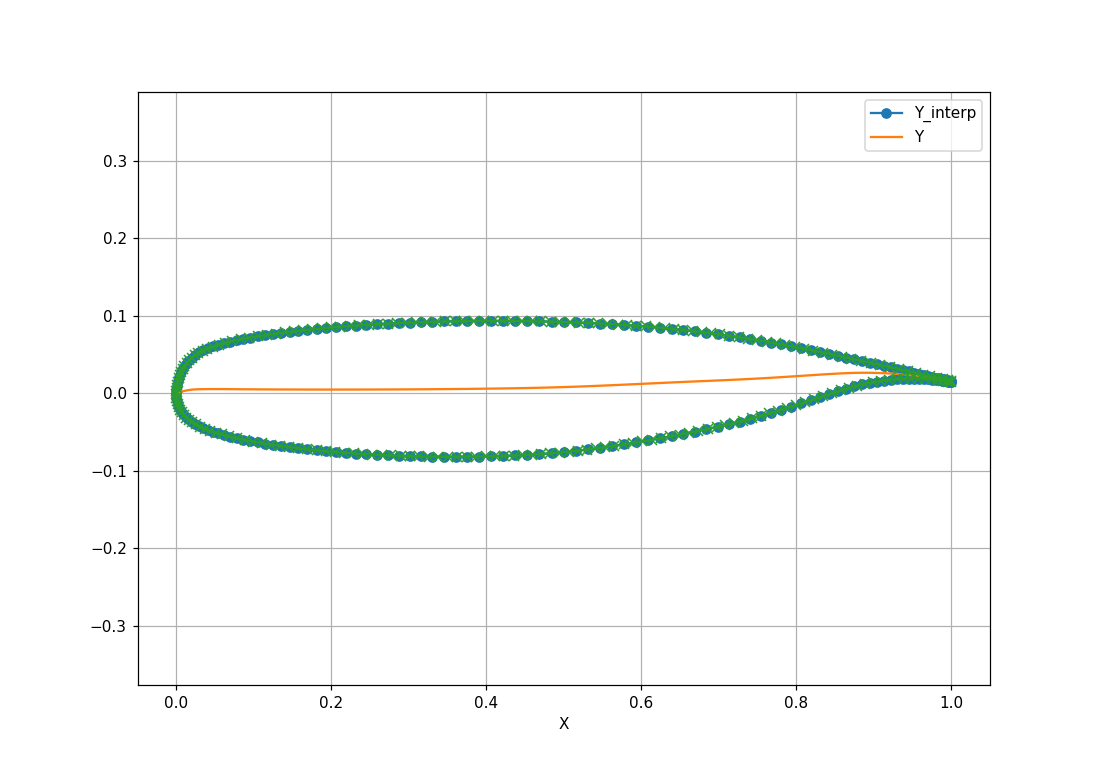

(-0.049999832, 1.049999992, -0.090438005, 0.102417405)

In [273]:
ax = main_common.set_index("X").plot(marker="o")
MEAN_LINE.plot(ax=ax)
main_df.set_index("X").plot(ax=ax, grid=True, marker="x")
plt.axis("equal")

In [274]:
def rotate_around_center(points, deg, center):
    """Rotate points around a center in space.

    Parameters
    ----------
    points : np.array 2xN
    deg : float
    center : np.array 2x1

    Returns
    -------
    rotated : np.array 2xN
    """
    rad = np.deg2rad(deg)
    c, s = np.cos(rad), np.sin(rad)
    A = np.array([[c, s], [-s, c]])

    # The following transposing is done, because numpy subtracts 1x2 arrays from a Nx2 array,
    # but not 2x1 arrays form an 2xN array.

    x = points
    rotated = ((A @ ((x.T - center.T).T)).T + center.T).T

    return rotated

In [275]:
def smooth(x, window_len=11, window="hanning"):
    """Smooth the data using a window with requested size.
    
    Parameters
    ----------
    x : numpy.array 
        Input signal
    window_len : int
        Dimension of the smoothing window; should be an odd integer
    window: str
        Window type from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
        "flat" window will produce a moving average smoothing.

    Returns
    -------
    y : numpy.array
        Smoothed signal
    
    Example
    -------
    >> t=linspace(-2,2,0.1)
    >> x=sin(t)+randn(len(t))*0.1
    >> y=smooth(x)

    Notes
    -----    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.

    See also
    --------
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
    
    Source
    ------
    https://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
    """

    if x.ndim != 1:
        raise ValueError("Smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")

    if not window in ["flat", "hanning", "hamming", "bartlett", "blackman"]:
        raise ValueError(
            f"Window {window} is not one of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"
        )

    s = np.r_[x[window_len - 1 : 0 : -1], x, x[-2 : -window_len - 1 : -1]]

    if window == "flat":  # moving average
        w = np.ones(window_len, "d")
    else:
        w = eval("np." + window + "(window_len)")

    y = np.convolve(w / w.sum(), s, mode="valid")
    
    # Return same dimensions as the original signal
    y = y[(window_len//2-1):-(window_len//2)]

    return y

In [276]:
def create_plain_flap(coordinates, hinge, delta, smooth_result=True):
    """Create a plain flap by deflecting the points beyond and w.r.t. 
    to a hinge location.

    Parameters
    ----------
    coordinates : numpy.array
        Size 2xN 
    hinge : float
    delta : float
    smooth : bool
        Perform smoothing, by default True.
        
    Returns
    -------
    main_flap : numpy.array
        Size 2xN
        
    Notes
    -----
    The hinge point is located in the mean line, 
    stored in the MEAN_LINE variable.
    """

    mask = MEAN_LINE.index >= hinge

    center_x = MEAN_LINE.index[mask][0]
    center_y = MEAN_LINE.loc[center_x]

    CENTER = np.r_[center_x, center_y]

    # Get index locations to select points to rotate
    _until, _from = np.argwhere(coordinates[0, :] == center_x).flatten()
    _until += 1  # Due to slicing criteria in numpy

    # Rotate airfoil
    _rotate = partial(rotate_around_center, deg=delta, center=CENTER)

    main_flap = coordinates.copy()

    main_flap[:, :_until] = _rotate(points=coordinates[:, :_until])
    main_flap[:, _from:] = _rotate(points=coordinates[:, _from:])

    # Smooth out edges in the first rotation node
    if smooth_result == True:
        main_flap[1, :] = smooth(main_flap[1, :], window_len=10, window="hanning")

    return main_flap, CENTER

In [277]:
# This angle seems to present an horizontal airfoil
DELTAS = [-10, -5, 5, 10, 20]
HINGE = 0.8

<IPython.core.display.Javascript object>


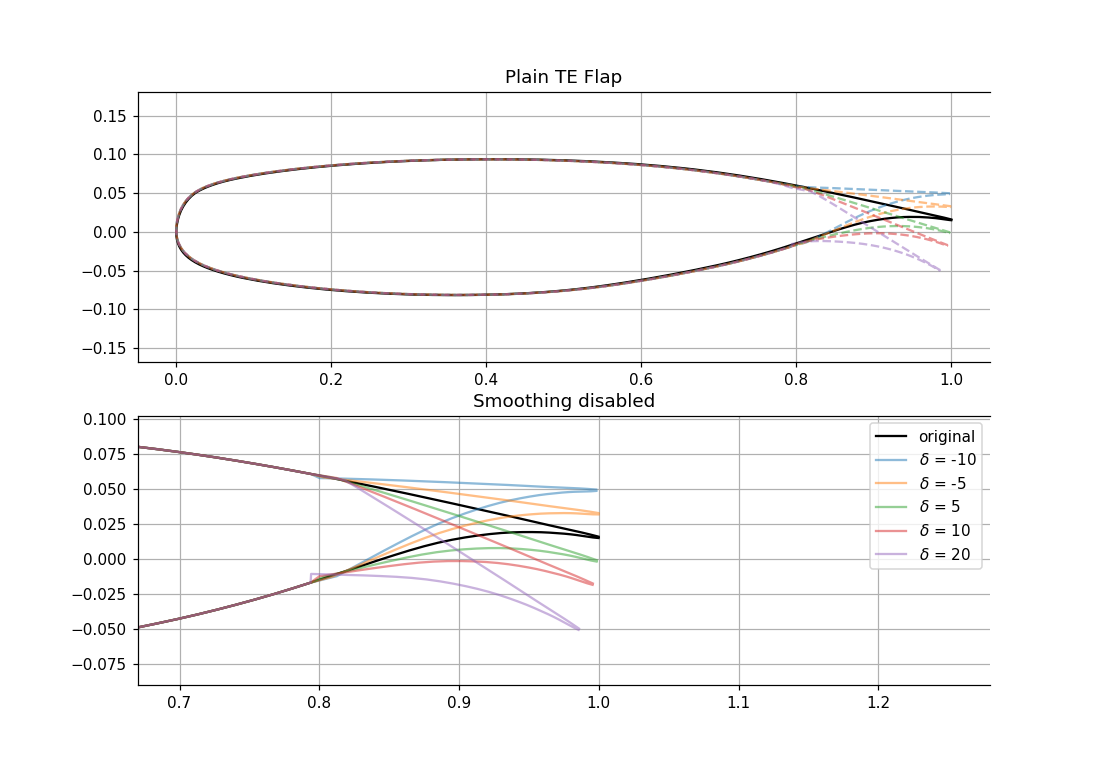

In [278]:
fig, axes = plt.subplots(2, 1)

smooth_airfoil = True
ax = axes[0]

plot_flap = partial(ax.plot, linestyle="--", alpha=0.5)

# To accomodate text on the plot
ax.spines["right"].set_visible(False)
ax.plot(MAIN[0, :], MAIN[1, :], "-k", label="original")

for delta in DELTAS:

    main_flap, hinge = create_plain_flap(
        coordinates=MAIN, hinge=HINGE, delta=delta, smooth_result=smooth_airfoil
    )

    # Plot geometry
    plot_flap(main_flap[0, :], main_flap[1, :])

ax.set_title(f"Plain TE Flap")
ax.axis("equal")
ax.grid()

smooth_airfoil = False
ax = axes[1]

plot_flap = partial(ax.plot, linestyle="-", alpha=0.5)

# To accomodate text on the plot
ax.spines["right"].set_visible(False)
ax.plot(MAIN[0, :], MAIN[1, :], "-k", label="original")

for delta in DELTAS:

    main_flap, hinge = create_plain_flap(
        coordinates=MAIN, hinge=HINGE, delta=delta, smooth_result=smooth_airfoil
    )

    # Plot geometry
    plot_flap(main_flap[0, :], main_flap[1, :], label = f"$\delta$ = {delta}")

ax.set_title(f"Smoothing disabled")
ax.axis("equal")
ax.set_xlim(left = 0.9, right = None)
ax.legend(loc ="best", ncol=1)
ax.grid()

savefig(fname="Plain_flap_sketch.png")

## Viiflow Parameters
All calculations have been performed with a Reynolds Number of 2.51E6 and a Mach Number of 0 or 0.185 using a Karman-Tsien correction for the pressure and lift. A critical amplification factor of 8 was used, while 11.2 seems to be recommended for the Delft low-speed wind tunnel[5].
However, the lower value agrees better with the observed transition (see the pressure distributions below).

In [279]:
def simulate(main, delta=None, hinge=None, alpha=None):
    """Perform simulation.

    Parameters
    ----------
    main : np.array
    delta : float
        Degrees to rotate the flap.
    hinge : float
        Hinge location in the x coordinate.
    alpha : float
        Angle of attack in degrees.

    Returns
    -------
    results : dict
    panels :
    boundary_layer :

    Notes
    -----
    The hinge point is located in the mean line.
    """

    # Locate the hinge point
    if delta is None:
        main_flap = main
        delta = 0
    else:
        main_flap, hinge_point = create_plain_flap(
            hinge=hinge,
            delta=delta,
            coordinates=main,
            smooth_result=True,
        )

    # Prepare solver
    s = vf.setup(
        Re=REYNOLDS,
        Ncrit=NCRIT,
        Ma=MACH,
        Itermax=ITERMAX,
        Tolerance=TOL,
    )
    s.Silent = True  # Do not show information on convergence and iterations

    # RFOIL-type shear lag fits the measurement slightly better (lower maximum lift)
    s.ShearLagType = 1

    # Dictionary of results
    results = defaultdict(list)

    # Define angles of attack to solve
    if alpha is None:
        AOArange = np.linspace(AOA_START, AOA_END, num=AOA_N)
    else:
        AOArange = [alpha]

    for _alpha in AOArange:

        s.Alpha = _alpha

        # Create inviscid solution and initial boundary layer
        [p, bl, xn] = vf.init([main_flap], s)

        # Iterate towards convergence
        res = None
        grad = None
        [xn, flag, res, grad, _] = vf.iter(xn, bl, p, s, res, grad)

        resi = np.sqrt(np.dot(res.T, res))
        resi = np.log10(resi)

        flag = bool(flag)

        results["AOA"].append(_alpha)
        results["delta"].append(delta)
        results["CL"].append(p.CL)
        results["CLi"].append(p.CLi)
        results["CD"].append(bl[0].CD)
        results["residual"].append(resi)
        results["convergence"].append(flag)

    # Output results
    panels = p
    boundary_layer = bl

    return results, panels, boundary_layer

In [280]:
# Settings
REYNOLDS = 2.51e6
NCRIT = 8
MACH = 0.0
ITERMAX = 150
TOL = 1e-4

AOA_START = -10.0
AOA_END = 25
AOA_N = 12

results_raw = pd.DataFrame()

_results, _, _ = simulate(main = MAIN)
_results = pd.DataFrame(_results)    
results_raw = results_raw.append(_results)

for delta in DELTAS:
    
    _results, _, _ = simulate(main = MAIN, delta = delta, hinge = HINGE)
    
    # Store as DF
    _results = pd.DataFrame(_results)    
    results_raw = results_raw.append(_results)

 xi=0.084894,delta=0.000085,theta=0.000078,ue=1.340853,typ=turbulent,
 res=[0.0280703,-0.0293432,-0.0011725]
 dx=[-3.75624e-06,0.0316694,0.00370962]
 x=[7.84517e-05,1.34085,0.0343974] 
 lam=1.000000 H=1.077153 HS=1.952868 US=0.892170.

 xi=0.085835,delta=0.000037,theta=0.000017,ue=2.207567,typ=laminar,
 res=[0.382281,-0.8045,7.98579e-06]
 dx=[-8.3859e-05,0.209794,7.99814e-05]
 x=[1.72296e-05,2.20757,7.7907] 
 lam=0.051365 H=2.165103 HS=1.631878 US=0.000000.

 xi=0.031350,delta=0.000092,theta=0.000051,ue=0.250616,typ=laminar,
 res=[0.0316092,-0.0678597,2.71051e-20]
 dx=[4.5232e-06,-0.0010982,-9.57601e-06]
 x=[5.08395e-05,0.250616,0.000252949] 
 lam=1.000000 H=1.810799 HS=1.711155 US=0.000000.

 xi=0.142115,delta=0.000311,theta=0.000028,ue=2.039266,typ=turbulent,
 res=[0.0133608,0.0688039,0.000294017]
 dx=[-2.19529e-05,0.045735,-0.0015102]
 x=[2.82694e-05,2.03927,0.000669619] 
 lam=0.110849 H=10.986277 HS=1.727913 US=-0.082208.

 xi=0.896007,delta=0.000005,theta=0.000003,ue=4.576786,typ=

 xi=0.822216,delta=0.000000,theta=0.000000,ue=2027.723553,typ=laminar,
 res=[0.473423,-1.10347,-3.10861e-17]
 dx=[3.08797e-09,69.5103,3.10861e-17]
 x=[3.00477e-08,2027.72,4.09782] 
 lam=1.000000 H=1.709822 HS=1.741278 US=0.000000.

 xi=0.822234,delta=0.000000,theta=0.000000,ue=4925.115723,typ=laminar,
 res=[0.369051,-1.08735,2.51017e-09]
 dx=[-2.51017e-09,-281.898,2.51017e-09]
 x=[1.81028e-08,4925.12,4.09732] 
 lam=1.000000 H=1.702813 HS=1.743517 US=0.000000.

 xi=0.822234,delta=0.000000,theta=0.000000,ue=4925.115723,typ=laminar,
 res=[0.369051,-1.08735,2.51017e-09]
 dx=[-2.51017e-09,-281.898,2.51017e-09]
 x=[1.81028e-08,4925.12,4.09732] 
 lam=1.000000 H=1.702813 HS=1.743517 US=0.000000.

 xi=0.822246,delta=0.000000,theta=0.000000,ue=11113.831037,typ=laminar,
 res=[2.52417,-5.77187,2.12399e-09]
 dx=[-2.84881e-09,-1303.53,2.84881e-09]
 x=[8.49597e-09,11113.8,4.09703] 
 lam=0.745571 H=2.176963 HS=1.629814 US=0.000000.

 xi=0.822246,delta=0.000000,theta=0.000000,ue=11113.831037,typ=lamina

 xi=0.822262,delta=0.000000,theta=0.000000,ue=428785951.466533,typ=laminar,
 res=[2.86863,-9.08298,5.55969e-13]
 dx=[1.2554e-11,5.58102e+07,-1.39263e-12]
 x=[4.52692e-11,4.28786e+08,4.09658] 
 lam=0.600993 H=1.482261 HS=1.825291 US=0.000000.

 xi=0.822262,delta=0.000000,theta=0.000000,ue=1042814625.154361,typ=laminar,
 res=[0.101724,-0.29617,7.45151e-13]
 dx=[-7.44945e-13,-1.4028e+07,-3.19061e-13]
 x=[2.26354e-11,1.04281e+09,4.09658] 
 lam=1.000000 H=1.778650 HS=1.720325 US=0.000000.

 xi=0.822262,delta=0.000000,theta=0.000000,ue=1042814625.154361,typ=laminar,
 res=[0.101724,-0.29617,7.45151e-13]
 dx=[-7.44945e-13,-1.4028e+07,-3.19061e-13]
 x=[2.26354e-11,1.04281e+09,4.09658] 
 lam=1.000000 H=1.778650 HS=1.720325 US=0.000000.

 xi=0.822262,delta=0.000000,theta=0.000000,ue=2749559321.226439,typ=laminar,
 res=[0.093085,-0.262077,4.07643e-13]
 dx=[-4.07926e-13,-3.46494e+07,-8.76466e-14]
 x=[1.3485e-11,2.74956e+09,4.09658] 
 lam=1.000000 H=1.791348 HS=1.716658 US=0.000000.

 xi=0.822262,de

 xi=0.869534,delta=0.000002,theta=0.000001,ue=157.943432,typ=turbulent,
 res=[1.02776,-0.447563,-4.23217e-06]
 dx=[-5.34042e-08,-2.22931e-05,9.84442e-06]
 x=[1.26156e-06,157.943,0.000396103] 
 lam=1.000000 H=1.661749 HS=1.707081 US=0.444022.

 xi=0.869599,delta=0.000003,theta=0.000002,ue=85.226843,typ=turbulent,
 res=[-0.850264,-1.50107,1.4632e-05]
 dx=[4.93758e-07,-4.54289,1.97834e-05]
 x=[2.08026e-06,85.2268,0.000719763] 
 lam=0.702185 H=1.410864 HS=1.792910 US=0.581924.

 xi=0.869627,delta=0.000002,theta=0.000001,ue=181.899418,typ=turbulent,
 res=[1.75479,-2.9202,0.000217431]
 dx=[2.03219e-07,-29.3903,4.67999e-05]
 x=[9.27045e-07,181.899,0.000340773] 
 lam=0.760299 H=1.899558 HS=1.657379 US=0.355876.

 xi=0.869219,delta=0.000002,theta=0.000001,ue=206.683749,typ=turbulent,
 res=[0.174435,-0.0645479,2.65693e-07]
 dx=[-4.44713e-09,-2.07745,3.10254e-06]
 x=[1.03235e-06,206.684,0.000301188] 
 lam=1.000000 H=1.666245 HS=1.703142 US=0.441331.

 xi=0.868931,delta=0.000002,theta=0.000001,ue=

 xi=0.866429,delta=0.000004,theta=0.000003,ue=57.843664,typ=turbulent,
 res=[-0.107551,-1.7416,1.99034e-05]
 dx=[8.589e-07,0.0708648,-2.93329e-05]
 x=[2.70351e-06,57.8437,0.000977581] 
 lam=0.524607 H=1.398255 HS=1.801296 US=0.591581.

 xi=0.866399,delta=0.000002,theta=0.000001,ue=131.074972,typ=turbulent,
 res=[3.50756,-4.48496,6.68691e-05]
 dx=[-3.75005e-07,15.1242,-4.44909e-05]
 x=[1.07265e-06,131.075,0.000443915] 
 lam=0.715088 H=2.114508 HS=1.622079 US=0.296003.

 xi=0.866363,delta=0.000003,theta=0.000002,ue=77.181053,typ=turbulent,
 res=[1.93278,-2.49682,3.34405e-05]
 dx=[-2.94257e-07,-4.89911,5.77927e-05]
 x=[1.69351e-06,77.1811,0.000748262] 
 lam=1.000000 H=1.875014 HS=1.666769 US=0.364811.

 xi=0.866376,delta=0.000002,theta=0.000001,ue=171.866811,typ=turbulent,
 res=[1.31515,-1.13173,4.05328e-05]
 dx=[-4.4832e-08,-10.8749,1.98271e-05]
 x=[1.10425e-06,171.867,0.000334067] 
 lam=1.000000 H=1.725353 HS=1.692100 US=0.417512.

 xi=0.866301,delta=0.000003,theta=0.000002,ue=108.04151

 xi=0.865212,delta=0.000002,theta=0.000001,ue=130.818940,typ=turbulent,
 res=[1.52915,-2.41497,0.000183904]
 dx=[2.55218e-07,-24.4089,5.59112e-05]
 x=[1.17261e-06,130.819,0.000418105] 
 lam=0.765755 H=1.819474 HS=1.677665 US=0.383649.

 xi=0.865096,delta=0.000003,theta=0.000002,ue=93.642749,typ=turbulent,
 res=[2.06713,-1.32341,0.000230642]
 dx=[-2.76073e-07,11.9587,-8.64799e-05]
 x=[1.84779e-06,93.6427,0.000574787] 
 lam=1.000000 H=1.616492 HS=1.725713 US=0.466383.

 xi=0.865084,delta=0.000004,theta=0.000003,ue=52.862206,typ=turbulent,
 res=[0.688711,-1.89496,1.88764e-06]
 dx=[1.11215e-06,-5.53737,6.09935e-05]
 x=[2.96919e-06,52.8622,0.00102072] 
 lam=0.444963 H=1.408369 HS=1.797491 US=0.584771.

 xi=0.864996,delta=0.000003,theta=0.000002,ue=103.731565,typ=turbulent,
 res=[-0.501456,-1.35994,5.70967e-05]
 dx=[3.97964e-07,-9.27904,3.34552e-05]
 x=[1.70161e-06,103.732,0.000519787] 
 lam=0.712632 H=1.474504 HS=1.770041 US=0.541882.

 xi=0.864927,delta=0.000004,theta=0.000002,ue=63.008817

 xi=0.863464,delta=0.000004,theta=0.000003,ue=45.579483,typ=turbulent,
 res=[1.38132,-1.80477,-2.89706e-05]
 dx=[-4.45389e-07,0.581283,2.5869e-06]
 x=[2.68034e-06,45.5795,0.00112985] 
 lam=1.000000 H=1.665304 HS=1.717350 US=0.445364.

 xi=0.863504,delta=0.000003,theta=0.000001,ue=95.129160,typ=turbulent,
 res=[2.49924,-3.27983,0.000354429]
 dx=[-2.6058e-07,-16.6349,8.34468e-05]
 x=[1.3655e-06,95.1292,0.000533014] 
 lam=1.000000 H=1.961303 HS=1.649536 US=0.337723.

 xi=0.863531,delta=0.000004,theta=0.000002,ue=62.697924,typ=turbulent,
 res=[2.32094,-2.11971,-2.81638e-05]
 dx=[-4.36965e-07,2.32005,-1.67828e-05]
 x=[2.18483e-06,62.6979,0.000822283] 
 lam=1.000000 H=1.716115 HS=1.703214 US=0.423455.

 xi=0.863571,delta=0.000002,theta=0.000001,ue=125.709884,typ=turbulent,
 res=[2.72334,-3.22707,2.77045e-05]
 dx=[-1.86096e-07,-6.71595,2.7935e-05]
 x=[1.17005e-06,125.71,0.000412023] 
 lam=1.000000 H=1.922691 HS=1.656049 US=0.349271.

 xi=0.863789,delta=0.000003,theta=0.000001,ue=94.950069,typ

 xi=0.862626,delta=0.000004,theta=0.000003,ue=52.812049,typ=turbulent,
 res=[0.927417,-2.21427,-1.73107e-05]
 dx=[9.63621e-07,0.197122,-3.44159e-05]
 x=[2.67932e-06,52.812,0.000928632] 
 lam=0.463412 H=1.467152 HS=1.776909 US=0.547623.

 xi=0.862605,delta=0.000002,theta=0.000001,ue=114.638714,typ=turbulent,
 res=[2.86206,-3.58705,0.00014752]
 dx=[-2.24585e-07,-11.9614,4.92193e-05]
 x=[1.1961e-06,114.639,0.000432911] 
 lam=1.000000 H=1.971900 HS=1.647064 US=0.334498.

 xi=0.862563,delta=0.000003,theta=0.000002,ue=72.429421,typ=turbulent,
 res=[0.943038,-2.21584,-9.55502e-06]
 dx=[9.34489e-07,-6.47291,3.08754e-05]
 x=[2.27722e-06,72.4294,0.000674635] 
 lam=0.406144 H=1.450021 HS=1.781307 US=0.557619.

 xi=0.862561,delta=0.000005,theta=0.000002,ue=37.848209,typ=turbulent,
 res=[0.80654,-2.56423,5.75674e-05]
 dx=[-1.26146e-06,-4.4672,0.000187188]
 x=[2.38388e-06,37.8482,0.00131279] 
 lam=0.472444 H=1.939206 HS=1.657628 US=0.345181.

 xi=0.862530,delta=0.000003,theta=0.000002,ue=93.675330,t

 xi=0.743139,delta=0.000000,theta=0.000000,ue=1132.084413,typ=turbulent,
 res=[-0.974151,-9.78956,5.42582e-05]
 dx=[2.32767e-06,-9837.45,-0.0104285]
 x=[2.2581e-07,1132.08,0.000802822] 
 lam=0.016169 H=1.958955 HS=1.627481 US=0.333807.

 xi=0.743139,delta=0.000000,theta=0.000000,ue=1333.120926,typ=turbulent,
 res=[5.75547,-12.4311,3.79784e-05]
 dx=[7.2433e-08,-173.664,-0.000371519]
 x=[2.07209e-07,1333.12,0.000808203] 
 lam=0.476783 H=2.134612 HS=1.593918 US=0.286588.

 xi=0.743139,delta=0.000000,theta=0.000000,ue=1455.512516,typ=turbulent,
 res=[15.954,-23.2841,3.67522e-05]
 dx=[-1.88165e-07,622.376,0.000882804]
 x=[1.70581e-07,1455.51,0.000981856] 
 lam=0.185367 H=2.592654 HS=1.544178 US=0.200655.

 xi=0.743139,delta=0.000000,theta=0.000000,ue=1290.917240,typ=turbulent,
 res=[10.413,-18.6279,3.08021e-05]
 dx=[6.59915e-08,-347.946,-0.000239958]
 x=[1.87333e-07,1290.92,0.000980071] 
 lam=0.473124 H=2.360364 HS=1.568308 US=0.239652.

 xi=0.743139,delta=0.000000,theta=0.000000,ue=1340.26

 xi=1.770605,delta=0.000000,theta=0.000000,ue=69.368845,typ=wake,
 res=[-2.81023,-3.03217e+06,-0.000241491]
 dx=[1.21309e-17,77.9479,-4.90643e-06]
 x=[1.54586e-12,69.3688,5.49756e-08] 
 lam=0.002801 H=1.000123 HS=1.999921 US=0.999812.

 xi=2.099863,delta=0.000000,theta=0.000000,ue=4277.233747,typ=wake,
 res=[-0.420349,-247056,-6.11914e-05]
 dx=[-1.69433e-16,721.298,-1.46186e-10]
 x=[1.54576e-12,4277.23,2.39452e-12] 
 lam=0.004095 H=1.000238 HS=1.999848 US=0.999638.

 xi=1.905957,delta=0.000000,theta=0.000000,ue=4818.351002,typ=wake,
 res=[-0.309244,-224558,-8.25894e-05]
 dx=[-2.0753e-16,597.432,-4.15559e-07]
 x=[1.54509e-12,4818.35,5.90296e-09] 
 lam=0.003551 H=1.000242 HS=1.999845 US=0.999630.

 xi=1.885793,delta=0.000000,theta=0.000000,ue=166.378091,typ=wake,
 res=[-2.18998,-1.82553e+06,-0.00022477]
 dx=[-6.50899e-18,145.792,-1.50097e-05]
 x=[1.03053e-12,166.378,1.67772e-07] 
 lam=0.002794 H=1.000099 HS=1.999937 US=0.999850.

 xi=2.276331,delta=0.000000,theta=0.000000,ue=480.812290,t

In [281]:
results_per_delta = dict()
DELTAS = sorted(results_raw["delta"].unique())

for _delta in DELTAS:
    
    # Filter results
    mask_delta = results_raw["delta"] == _delta
    mask_conv = results_raw["convergence"] == True
    mask = mask_delta & mask_conv
    
    _results = results_raw.loc[mask]
    
    results_per_delta[_delta] = _results.copy()

<IPython.core.display.Javascript object>


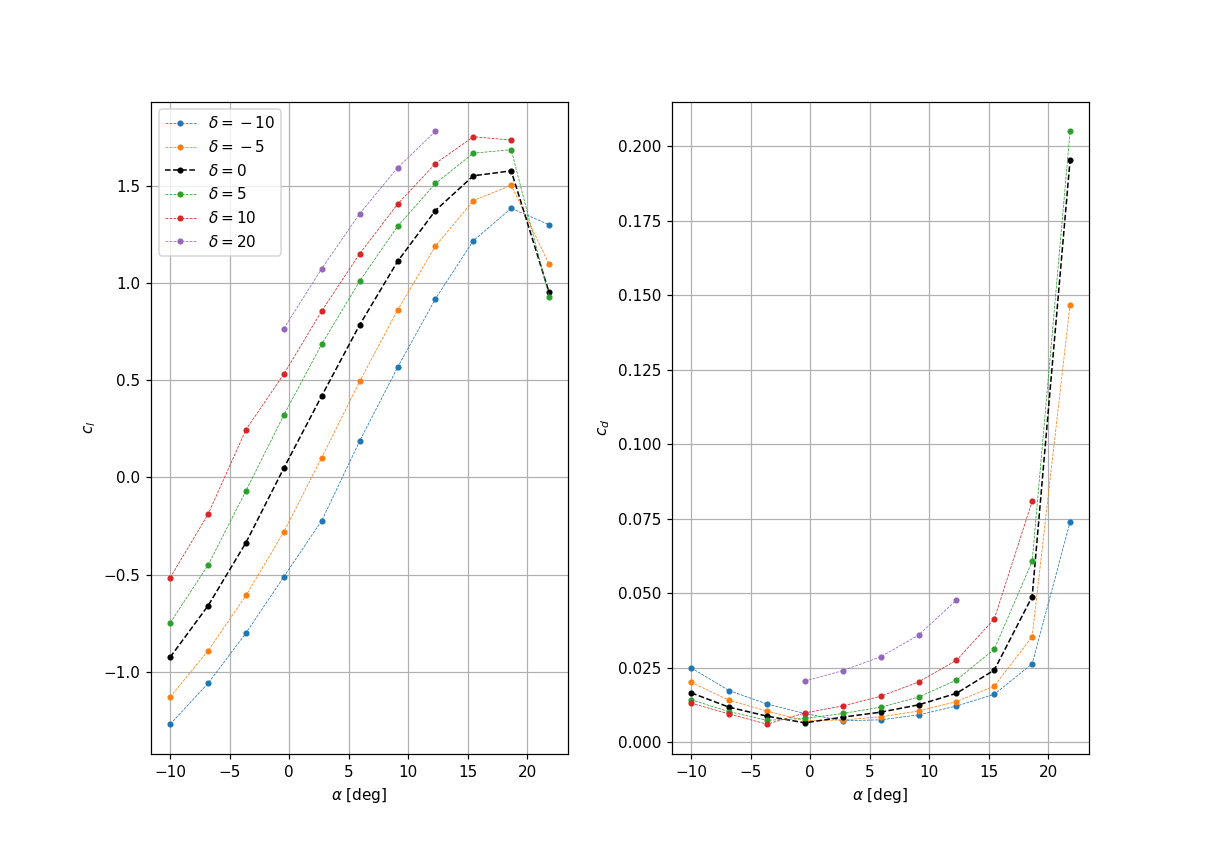

In [283]:
# LIFT
fig, ax = plt.subplots(1, 2, gridspec_kw = {"wspace":0.25})

color_exp = "black"

for delta in DELTAS:

    # Unpack results
    _results = results_per_delta[delta]
    
    if _results.empty == True:
        continue
    
    delta_eff = delta

    if delta == 0:
        color = color_exp
        linewidth = 1.0
    else:
        color = None
        linewidth = 0.5

    ax[0].plot(
        _results["AOA"],
        _results["CL"],
        marker=".",
        linestyle="--",
        linewidth=linewidth,
        color=color,
        label=f"$\delta = {delta_eff}$",
    )
    
    ax[1].plot(
        _results["AOA"],
        _results["CD"],
        marker=".",
        linestyle="--",
        linewidth=linewidth,
        color=color,
        label=f"$\delta = {delta_eff}$",
    )

ax[0].set_xlabel("$\\alpha$ [deg]")
ax[0].set_ylabel("$c_l$")
ax[0].legend()
ax[0].grid()

ax[1].set_xlabel("$\\alpha$ [deg]")
ax[1].set_ylabel("$c_d$")
ax[1].grid()

savefig(fname="lift_drag_polar_plain_flap.png")

The viscous calculations accurately predict the change in lift slope compared to the inviscid calculations. 
Applying the Mach corrections does result in a worse prediction compared to the incompressible calculation.
This seems to be in line with the results in [2], where the authors choose not to use a Mach correction for this case, but do use one for another case at the same Mach number.
In the following, the pressure distributions are compared to the incompressible calculations.

In [300]:
DISPLACEMENT = 1.0

# Shorthand for plotting all info for a single AOA from the csv dataset
def plot_cp_exp(ax, data, plot_transition=False):

    plotter_cp = partial(ax.plot, linestyle="None", color="tab:blue", marker="o")
    plotter_transition = partial(
        ax.plot,
        linestyle="None",
        color="tab:orange",
        marker="D",
    )

    plotter_cp(
        data["EXPMAINCP_X"],
        data["EXPMAINCP_Y"],
        label="Experiment",
    )
    plotter_cp(
        data["EXPFLAPCP_X"] + DISPLACEMENT,
        data["EXPFLAPCP_Y"],
    )

    if plot_transition == True:
        plotter_transition(
            data["EXPMAINTR_X"],
            data["EXPMAINTR_Y"],
            label="Experimental transition region",
        )
        plotter_transition(
            data["EXPFLAPTR_X"] + DISPLACEMENT,
            data["EXPFLAPTR_Y"],
        )


# Shorthand for plotting all info from the calculations for a single AOA
def plot_cp(ax, p, bl, label=None, plot_transition=False, disp_idx=None):

    # A helper index, cp is a single array of pressures over all panel nodes
    # IMF = [range(0, p.foils[0].N), range(p.foils[0].N, p.foils[0].N + p.foils[1].N)]
    IMF = [range(0, p.foils[0].N)]

    plotter_cp = partial(ax.plot, marker="None")
    plotter_tr = partial(ax.plot, color="tab:red", marker="v")

    if label is None:
        _label = "Original"
        linestyle = "-"
    else:
        _label = f"$\delta = {label}$"
        linestyle = "--"

    x_coords = np.array(p.foils[0].X[0, :])

    if disp_idx is None:
        _disp = 0.0
    else:
        _disp = DISPLACEMENT
    x_coords += _disp * disp_idx

    plotter_cp(x_coords, -p.cp[IMF[0]], label=_label, linestyle=linestyle)

    if plot_transition == True:
        # Small hack, only works for TWO elements
        for k in range(1):
            tr_lo = np.interp(
                bl[k].ST + bl[k].bl_fl.node_tr_lo.xi[0],
                p.foils[k].S,
                p.foils[k].X[0, :] + k * DISPLACEMENT,
            )
            tr_up = np.interp(
                bl[k].ST - bl[k].bl_fl.node_tr_up.xi[0],
                p.foils[k].S,
                p.foils[k].X[0, :] + k * DISPLACEMENT,
            )
            cp_up = np.interp(
                bl[k].ST - bl[k].bl_fl.node_tr_up.xi[0],
                p.foils[k].S,
                np.asarray(p.cp[IMF[k]]).ravel(),
            )
            cp_lo = np.interp(
                bl[k].ST + bl[k].bl_fl.node_tr_lo.xi[0],
                p.foils[k].S,
                np.asarray(p.cp[IMF[k]]).ravel(),
            )

            plotter_tr(tr_lo, -cp_lo, label="Numerical transition point")
            plotter_tr(tr_up, -cp_up)

<IPython.core.display.Javascript object>


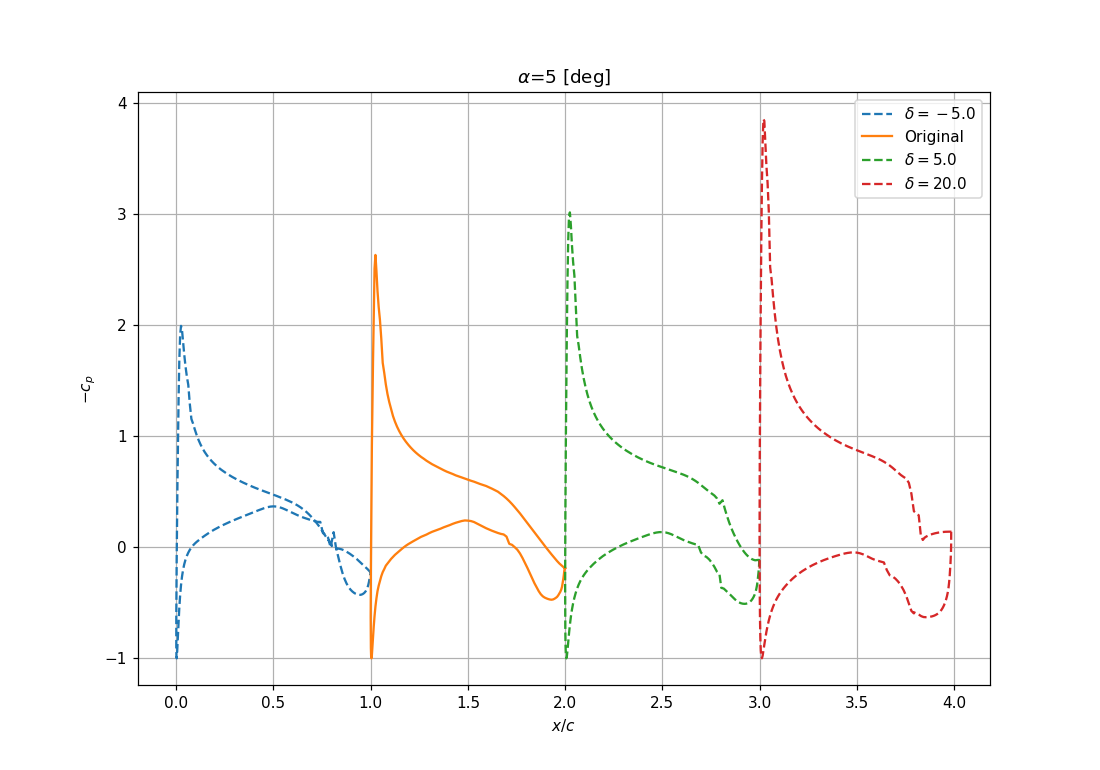

In [302]:
ALPHA = 5

fig, ax = plt.subplots(1,1)

deltas = [-5.0, None, 5.0, 20.0]
displacements = range(len(deltas))

for delta, disp in zip(deltas, displacements):

    # Experiment and simulation
    _results, p, bl = simulate(main=MAIN, hinge = HINGE, delta=delta, alpha=ALPHA)

    plot_cp(ax, p, bl, label = delta, disp_idx = disp)
    
    if delta is None:
        delta = 0 
    _, hinge_point = create_plain_flap(
            hinge=HINGE,
            delta=delta,
            coordinates=MAIN,
            smooth_result=False,
        )

# ax.plot(hinge_point[0], hinge_point[1], marker = "o")
ax.set_xlabel("$x/c$")
ax.set_ylabel("$-c_p$")
ax.set_title(f"$\\alpha$={ALPHA} [deg]")
ax.legend()
ax.grid()
    
savefig("pressure_distribution_validation_plain_flap.png")

In [325]:
p.foils[0].X.T

array([[ 9.85832917e-01, -4.94368153e-02],
       [ 9.85623275e-01, -4.94368153e-02],
       [ 9.84994553e-01, -4.91477101e-02],
       [ 9.83947379e-01, -4.85725675e-02],
       [ 9.82482775e-01, -4.77162862e-02],
       [ 9.80588254e-01, -4.65860495e-02],
       [ 9.78275951e-01, -4.51905752e-02],
       [ 9.75540610e-01, -4.35377469e-02],
       [ 9.72372568e-01, -4.16322206e-02],
       [ 9.68790957e-01, -3.94738349e-02],
       [ 9.64797692e-01, -3.70582898e-02],
       [ 9.60405872e-01, -3.43794716e-02],
       [ 9.55622262e-01, -3.14333414e-02],
       [ 9.50450653e-01, -2.82217624e-02],
       [ 9.44888912e-01, -2.47522289e-02],
       [ 9.38937740e-01, -2.10350272e-02],
       [ 9.32599484e-01, -1.70800330e-02],
       [ 9.25884378e-01, -1.28942083e-02],
       [ 9.18799439e-01, -8.48149030e-03],
       [ 9.11354053e-01, -3.84466118e-03],
       [ 9.03555219e-01,  1.01224920e-03],
       [ 8.95409767e-01,  6.08266857e-03],
       [ 8.86921703e-01,  1.13577400e-02],
       [ 8.

In [318]:
p.cp

array([-0.13925807, -0.13947608, -0.1396937 , -0.1398384 , -0.1399895 ,
       -0.1400681 , -0.14012762, -0.14014363, -0.1401186 , -0.14002891,
       -0.13985331, -0.13956028, -0.13911708, -0.13849176, -0.13765627,
       -0.13658281, -0.13523967, -0.13358337, -0.13155829, -0.12909253,
       -0.12609428, -0.12245811, -0.11805524, -0.11272914, -0.10626288,
       -0.09829745, -0.0876264 , -0.06568233, -0.10980964, -0.28741675,
       -0.32389284, -0.48155677, -0.57948252, -0.61744065, -0.63274888,
       -0.64985152, -0.67133389, -0.69353883, -0.71508264, -0.7351792 ,
       -0.75342873, -0.76975655, -0.78428127, -0.79722861, -0.80896142,
       -0.8199416 , -0.83052405, -0.84094302, -0.85144411, -0.86218504,
       -0.87314644, -0.88427744, -0.89569646, -0.90758979, -0.92006105,
       -0.93321144, -0.94718691, -0.96206136, -0.97781426, -0.99443443,
       -1.01197332, -1.03048141, -1.05006503, -1.07090948, -1.09315478,
       -1.11685567, -1.14204965, -1.16888307, -1.1976291 , -1.22

[1] B. van den Berg and B. Oskam. *Boundary layer measurements on a two-dimensional wing with flap and a comparison with calculations.* NLR MP 79034 U

[2] Cebeci, Tuncer, Eric Besnard, and Hsun Chen. *Calculation of multielement airfoil flows, including flap wells.* 34th Aerospace Sciences Meeting and Exhibit. 1996.

[3] Schwamborn, Dieter, et al. *Development of the DLR tau-code for aerospace applications.* Proceedings of the International Conference on Aerospace Science and Technology. Bangalore, India: National Aerospace Laboratories, 2008.

[4] Guo, Chuanliang. *Effects of turbulence modelling on the analysis and optimisation of high-lift configurations.* Master Thesis, Cranfield University

[5] Van Ingen, J. L. *The eN method for transition prediction: historical review of work at TU Delft.* AIAA, 2008.

[6] Godin, P., D. W. Zingg, and T. E. Nelson. *High-lift aerodynamic computations with one-and two-equation turbulence models.* AIAA journal 35.2 (1997): 237-243.

[7] Haase, W. et al. *ECARP - European Computational Aerodynamics Research Projects: Validation of CFD Codes and Assessment of Turbulence Models.* Notes on Numerical Fluid Mechanics, Vol. 58, 1997. 